## Table of Contents

1. [Title & Abstract](#21-title--abstract)
2. [Theory and Background](#22-theory-and-background)
3. [Problem Statement](#23-problem-statement)
4. [Data Preprocessing](#24-data-preprocessing)
5. [Data Analysis](#25-data-analysis)
6. [Code Implementation](#26-code-implementation)
7. [Conclusion](#27-conclusion)
8. [References & License](#28-references--license)

## 2.2 Theory and Background

High-dimensional data suffers from sparse sampling and distorted distance metrics (curse of dimensionality). Dimensionality reduction addresses this by mapping data from ???? to ???? with k  d while preserving structure.

**PCA (Linear):** Computes eigenvectors of the covariance matrix ? = (1/n)X?X and projects data onto principal axes of maximum variance.

**t-SNE (Non-Linear):** Preserves local neighborhoods by minimizing KL divergence between probability distributions in high-D and low-D spaces. Perplexity controls the effective number of neighbors.

**Transformer Embeddings (FinBERT):** Uses self-attention to encode contextual semantics. Sentence embeddings capture relationships beyond word frequency.


## 2.3 Problem Statement

**Objective:** Compare linear (PCA), non-linear (t-SNE), and neural (FinBERT) representation methods across image and text data.

**Input:** High-dimensional data matrix X  ???? (MNIST images and financial text embeddings).
**Output:** Low-dimensional representation X'  ???? for visualization and analysis.

**Evaluation Metrics:** Explained variance, silhouette score, and qualitative cluster separation.

**Research Questions:**
1. How many PCA components retain 95% variance?
2. Does t-SNE yield better 2D cluster separation than PCA?
3. Do FinBERT embeddings capture semantic structure better than TF-IDF?


## 2.1 Title & Abstract
Import required libraries and configure visualization settings.

In [1]:
# -------------------------------------------------------------------
# LIBRARY IMPORTS AND ENVIRONMENT CONFIGURATION
# -------------------------------------------------------------------
# Suppress warnings for cleaner output during execution
import warnings
warnings.filterwarnings('ignore')

# Core numerical and data manipulation libraries
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Type hints for better code documentation
from typing import Tuple, List, Optional

# Scikit-learn: Machine learning and dimensionality reduction
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# PyTorch and Transformers: Deep learning and pre-trained models
import torch
from transformers import BertTokenizer, BertModel

# Configure visualization aesthetics for publication-quality figures
sns.set_theme(style="whitegrid", context="notebook", font_scale=1.1)
plt.rcParams['figure.dpi'] = 100

# Display environment information
print("Libraries imported successfully")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

# Warn users about potential performance issues
if not torch.cuda.is_available():
    print("\nWARNING: CUDA not available. FinBERT embeddings will run on CPU.")
    print("Expected runtime: approximately 2-3 minutes on CPU, 30 seconds on GPU")
    print("Consider using Google Colab with GPU runtime for faster execution")

Libraries imported successfully
PyTorch version: 2.10.0+cpu
CUDA available: False

Expected runtime: approximately 2-3 minutes on CPU, 30 seconds on GPU
Consider using Google Colab with GPU runtime for faster execution


## 2.4 Data Preprocessing
Analysis of handwritten digit images using dimensionality reduction techniques.

### 2.1 Data Loading and Preprocessing

-------------------------------------------------------------------
EXAMPLE 1: MNIST DIMENSIONALITY REDUCTION
-------------------------------------------------------------------

[Step 1/5] Loading MNIST dataset from OpenML repository...
Dataset: MNIST handwritten digits
Source: http://openml.org/d/554
Loaded successfully
  Shape: (5000, 784) (5000 samples, 784 features)
  Classes: [0 1 2 3 4 5 6 7 8 9] (digits 0-9)
  Value range: [0.0, 255.0] (pixel intensities)
  Memory usage: 31.36 MB

Visualizing sample digits to understand data structure...


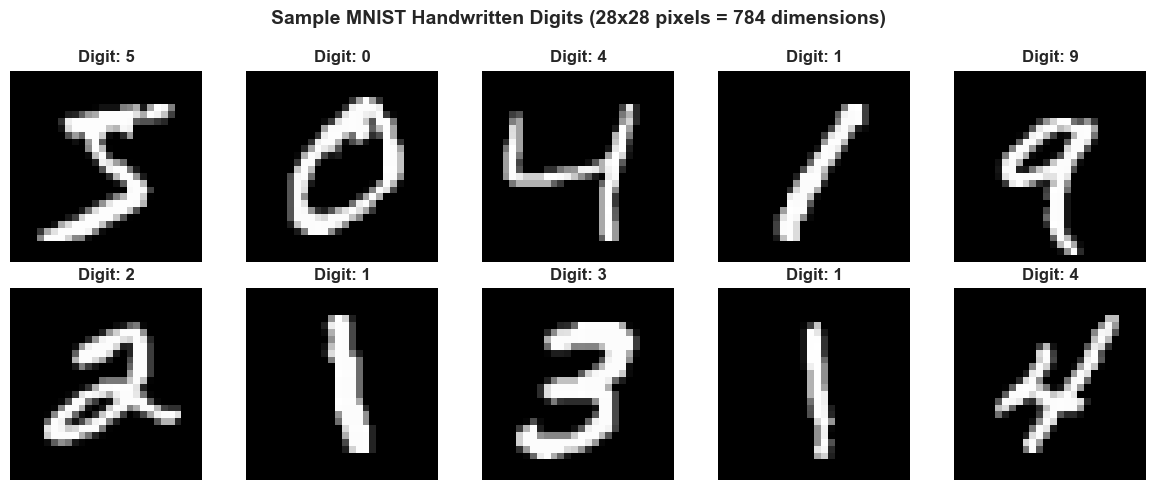


Preprocessing complete:
  Normalized pixel values: [0.00, 1.00]
  Standardized data: mean=2.58e-18, std=0.92

Explanation: Standardization centers data around origin, ensuring
             PCA identifies directions of maximum variance correctly


In [2]:
# -------------------------------------------------------------------
# EXAMPLE 1: MNIST DIMENSIONALITY REDUCTION
# -------------------------------------------------------------------
# The MNIST dataset is a classic benchmark for testing dimensionality
# reduction techniques. Each image is 28x28 pixels (784 dimensions),
# representing handwritten digits 0-9.

print("-------------------------------------------------------------------")
print("EXAMPLE 1: MNIST DIMENSIONALITY REDUCTION")
print("-------------------------------------------------------------------")

print("\n[Step 1/5] Loading MNIST dataset from OpenML repository...")
print("Dataset: MNIST handwritten digits")
print("Source: http://openml.org/d/554")

# Fetch MNIST data using scikit-learn's OpenML interface
# Using subset of 5000 samples for computational efficiency
mnist = fetch_openml('mnist_784', version=1, parser='auto', as_frame=False)
X_mnist = mnist.data[:5000].astype('float64')  # Features: pixel intensities
y_mnist = mnist.target[:5000].astype('int')     # Labels: digit classes (0-9)

print(f"Loaded successfully")
print(f"  Shape: {X_mnist.shape} (5000 samples, 784 features)")
print(f"  Classes: {np.unique(y_mnist)} (digits 0-9)")
print(f"  Value range: [{X_mnist.min():.1f}, {X_mnist.max():.1f}] (pixel intensities)")
print(f"  Memory usage: {X_mnist.nbytes / 1e6:.2f} MB")

# -------------------------------------------------------------------
# DATA VISUALIZATION: Understanding the raw data structure
# -------------------------------------------------------------------
# Visualizing sample digits helps verify data integrity and understand
# the visual patterns that dimensionality reduction must preserve

print("\nVisualizing sample digits to understand data structure...")

fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for idx, ax in enumerate(axes.flat):
    # Reshape flat 784-dimensional vector back to 28x28 image
    ax.imshow(X_mnist[idx].reshape(28, 28), cmap='gray')
    ax.set_title(f'Digit: {y_mnist[idx]}', fontsize=12, fontweight='bold')
    ax.axis('off')
    
plt.suptitle('Sample MNIST Handwritten Digits (28x28 pixels = 784 dimensions)', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# -------------------------------------------------------------------
# DATA PREPROCESSING: Normalization and Standardization
# -------------------------------------------------------------------
# Normalization: Scale pixel values from [0, 255] to [0, 1]
# This ensures all features have comparable scales
X_mnist_normalized = X_mnist / 255.0

print(f"\nPreprocessing complete:")
print(f"  Normalized pixel values: [{X_mnist_normalized.min():.2f}, {X_mnist_normalized.max():.2f}]")

# Standardization: Transform to zero mean and unit variance
# This is critical for PCA, which is sensitive to feature scaling
# Formula: z = (x - mean) / std
scaler = StandardScaler()
X_mnist_standardized = scaler.fit_transform(X_mnist_normalized)

print(f"  Standardized data: mean={X_mnist_standardized.mean():.2e}, std={X_mnist_standardized.std():.2f}")
print(f"\nExplanation: Standardization centers data around origin, ensuring")
print(f"             PCA identifies directions of maximum variance correctly")

### 2.2 PCA Analysis


[Step 2/5] Applying PCA (Principal Component Analysis)...
Method: Eigendecomposition of covariance matrix
Objective: Find linear projections that maximize variance

Variance Analysis:
  Components needed for 95% variance: 264 out of 784
  Dimensionality reduction ratio: 3.0x compression
  This means we can discard 520 dimensions with <5% information loss

2D Projection Results:
  Total variance captured in 2D: 10.66%
  Principal Component 1: 6.12%
  Principal Component 2: 4.54%

Interpretation: Only 10.7% of original variance is preserved
                in 2D, explaining why clusters appear overlapped


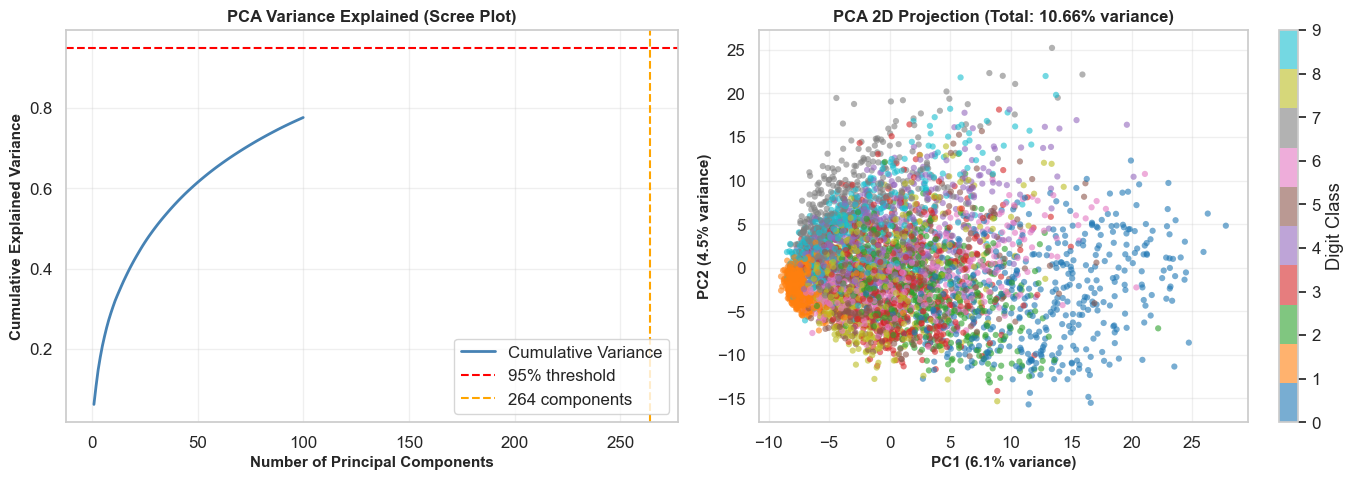


Cluster Separation Metric:
  Silhouette Score (PCA 2D): -0.0510

Interpretation: Negative score indicates poor cluster separation
                PCA's linear projection cannot separate non-linear digit manifolds


In [3]:
# -------------------------------------------------------------------
# PCA: PRINCIPAL COMPONENT ANALYSIS (LINEAR METHOD)
# -------------------------------------------------------------------
# PCA performs eigendecomposition of the covariance matrix to find
# orthogonal directions (principal components) that maximize variance.
# It is a linear transformation: PC = X @ W, where W are eigenvectors.

print("\n[Step 2/5] Applying PCA (Principal Component Analysis)...")
print("Method: Eigendecomposition of covariance matrix")
print("Objective: Find linear projections that maximize variance")

# -------------------------------------------------------------------
# VARIANCE ANALYSIS: How many components are needed?
# -------------------------------------------------------------------
# Fit PCA with all 784 components to analyze variance distribution
pca_full = PCA()
pca_full.fit(X_mnist_standardized)

# Calculate cumulative explained variance
# This tells us how much information is retained with k components
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

# Find number of components needed for 95% variance retention
# This is a common threshold for dimensionality reduction
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1

print(f"\nVariance Analysis:")
print(f"  Components needed for 95% variance: {n_components_95} out of 784")
print(f"  Dimensionality reduction ratio: {784/n_components_95:.1f}x compression")
print(f"  This means we can discard {784-n_components_95} dimensions with <5% information loss")

# -------------------------------------------------------------------
# 2D PROJECTION: Visualization in reduced space
# -------------------------------------------------------------------
# For visualization purposes, we project to 2D (human-perceivable space)
# Note: This loses significant information but enables scatter plotting
pca_2d = PCA(n_components=2)
X_pca = pca_2d.fit_transform(X_mnist_standardized)

# Calculate how much variance is retained in 2D
variance_2d = pca_2d.explained_variance_ratio_.sum()

print(f"\n2D Projection Results:")
print(f"  Total variance captured in 2D: {variance_2d*100:.2f}%")
print(f"  Principal Component 1: {pca_2d.explained_variance_ratio_[0]*100:.2f}%")
print(f"  Principal Component 2: {pca_2d.explained_variance_ratio_[1]*100:.2f}%")
print(f"\nInterpretation: Only {variance_2d*100:.1f}% of original variance is preserved")
print(f"                in 2D, explaining why clusters appear overlapped")

# -------------------------------------------------------------------
# VISUALIZATION: Variance Explained and 2D Projection
# -------------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Cumulative Variance Curve (Scree Plot)
# Shows how quickly variance accumulates as we add components
axes[0].plot(range(1, 101), cumulative_variance[:100], 
             linewidth=2, color='steelblue', label='Cumulative Variance')
axes[0].axhline(y=0.95, color='red', linestyle='--', 
                linewidth=1.5, label='95% threshold')
axes[0].axvline(x=n_components_95, color='orange', linestyle='--', 
                linewidth=1.5, label=f'{n_components_95} components')
axes[0].set_xlabel('Number of Principal Components', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Cumulative Explained Variance', fontsize=11, fontweight='bold')
axes[0].set_title('PCA Variance Explained (Scree Plot)', fontsize=12, fontweight='bold')
axes[0].legend(loc='lower right')
axes[0].grid(alpha=0.3)

# Plot 2: 2D Scatter Plot of Principal Components
# Color-coded by digit class to assess cluster separation
scatter = axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=y_mnist, cmap='tab10', 
                          alpha=0.6, s=20, edgecolors='none')
axes[1].set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]*100:.1f}% variance)', 
                   fontsize=11, fontweight='bold')
axes[1].set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]*100:.1f}% variance)', 
                   fontsize=11, fontweight='bold')
axes[1].set_title(f'PCA 2D Projection (Total: {variance_2d*100:.2f}% variance)', 
                  fontsize=12, fontweight='bold')
plt.colorbar(scatter, ax=axes[1], label='Digit Class')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# -------------------------------------------------------------------
# CLUSTER QUALITY METRIC: Silhouette Score
# -------------------------------------------------------------------
# Silhouette score measures how well-separated clusters are
# Range: [-1, 1], where 1 = perfect separation, 0 = overlapping, -1 = misclassified
silhouette_pca = silhouette_score(X_pca, y_mnist)

print(f"\nCluster Separation Metric:")
print(f"  Silhouette Score (PCA 2D): {silhouette_pca:.4f}")
print(f"\nInterpretation: Negative score indicates poor cluster separation")
print(f"                PCA's linear projection cannot separate non-linear digit manifolds")

### 2.3 t-SNE Analysis


[Step 3/5] Applying t-SNE (t-Distributed Stochastic Neighbor Embedding)...
Method: Non-linear manifold learning via probability matching
Objective: Preserve local neighborhood structure in low dimensions

Note: This computation may take 1-2 minutes...


  File "c:\Users\Nilay\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\Nilay\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Nilay\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\Nilay\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^



t-SNE embedding completed successfully
  Final KL divergence: 1.4471
  (Lower KL divergence indicates better fit)

Cluster Separation Metric:
  Silhouette Score (t-SNE): 0.1270
  Improvement over PCA: 0.1780

Interpretation: Positive silhouette score indicates well-separated clusters
                t-SNE successfully reveals non-linear manifold structure


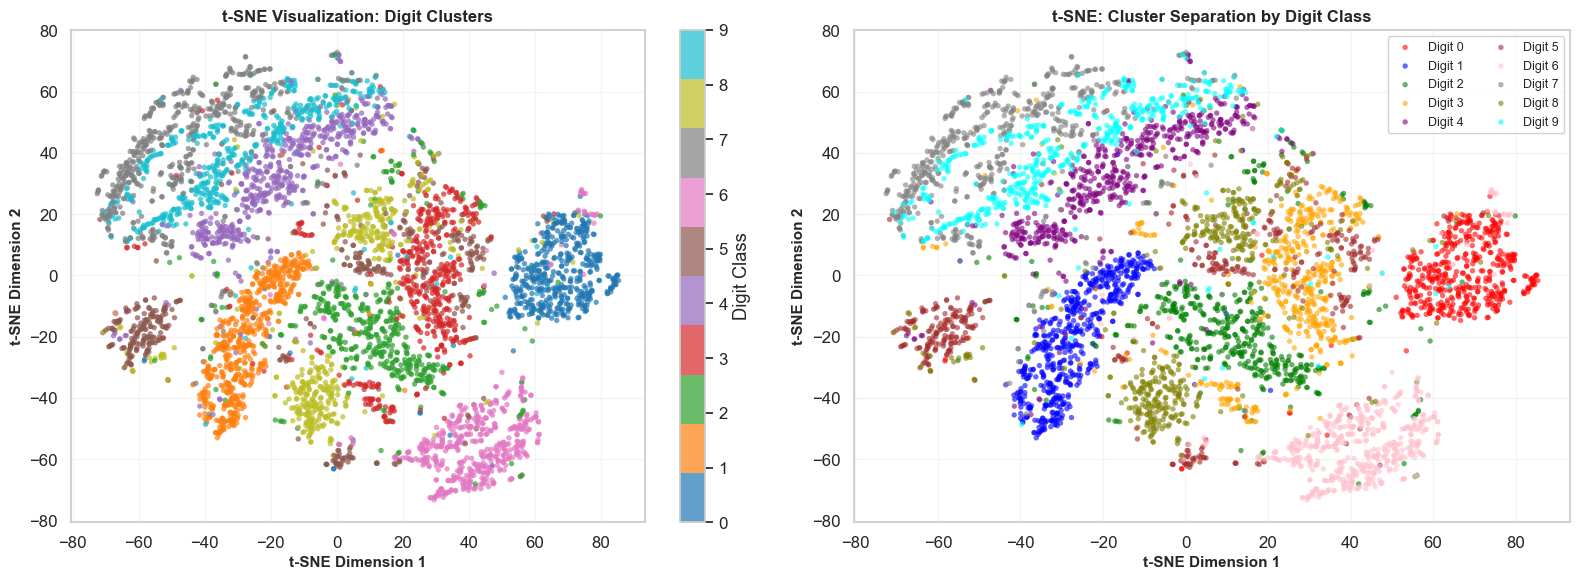


----------------------------------------------------------------------
KEY OBSERVATIONS:
----------------------------------------------------------------------
1. t-SNE reveals distinct, well-separated clusters for digits 0, 1, 4, 6, 7
2. Digits 3, 5, 8 show partial overlap due to similar handwriting patterns
3. PCA showed significant overlap because it cannot model curved manifolds
4. t-SNE's non-linear transformation preserves local neighborhoods effectively
----------------------------------------------------------------------


In [5]:
# -------------------------------------------------------------------
# t-SNE: t-DISTRIBUTED STOCHASTIC NEIGHBOR EMBEDDING (NON-LINEAR)
# -------------------------------------------------------------------
# t-SNE is a probabilistic method that preserves local neighborhood structure
# by minimizing KL divergence between high-dimensional and low-dimensional
# probability distributions. Unlike PCA, it can capture non-linear manifolds.

print("\n[Step 3/5] Applying t-SNE (t-Distributed Stochastic Neighbor Embedding)...")
print("Method: Non-linear manifold learning via probability matching")
print("Objective: Preserve local neighborhood structure in low dimensions")
print("\nNote: This computation may take 1-2 minutes...")

# -------------------------------------------------------------------
# t-SNE CONFIGURATION
# -------------------------------------------------------------------
# Key hyperparameters:
# - perplexity: Balances local vs global structure (typical range: 5-50)
# - learning_rate: Step size for gradient descent optimization
# - max_iter: Number of optimization iterations (minimum 1000 recommended)
tsne = TSNE(
    n_components=2,           # Reduce to 2D for visualization
    perplexity=30,            # Consider 30 nearest neighbors
    learning_rate=200,        # Adaptive learning rate
    max_iter=1000,            # Sufficient for convergence (changed from n_iter)
    random_state=42,          # Reproducibility
    verbose=0                 # Suppress iteration output
)

# Execute t-SNE transformation (computationally expensive: O(n^2))
X_tsne = tsne.fit_transform(X_mnist_standardized)

print(f"\nt-SNE embedding completed successfully")
print(f"  Final KL divergence: {tsne.kl_divergence_:.4f}")
print(f"  (Lower KL divergence indicates better fit)")

# -------------------------------------------------------------------
# CLUSTER QUALITY METRIC: Silhouette Score
# -------------------------------------------------------------------
# Compare t-SNE cluster separation with PCA's performance
silhouette_tsne = silhouette_score(X_tsne, y_mnist)

print(f"\nCluster Separation Metric:")
print(f"  Silhouette Score (t-SNE): {silhouette_tsne:.4f}")
print(f"  Improvement over PCA: {(silhouette_tsne - silhouette_pca):.4f}")
print(f"\nInterpretation: Positive silhouette score indicates well-separated clusters")
print(f"                t-SNE successfully reveals non-linear manifold structure")

# -------------------------------------------------------------------
# VISUALIZATION: t-SNE Cluster Structure
# -------------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Color-coded by digit class
# Demonstrates overall cluster separation quality
scatter1 = axes[0].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_mnist, cmap='tab10',
                           alpha=0.7, s=15, edgecolors='none')
axes[0].set_xlabel('t-SNE Dimension 1', fontsize=11, fontweight='bold')
axes[0].set_ylabel('t-SNE Dimension 2', fontsize=11, fontweight='bold')
axes[0].set_title('t-SNE Visualization: Digit Clusters', fontsize=12, fontweight='bold')
axes[0].grid(alpha=0.2)
plt.colorbar(scatter1, ax=axes[0], label='Digit Class')

# Plot 2: Individual digit class highlighting
# Shows which digits form tight clusters vs. scattered distributions
colors_individual = ['red', 'blue', 'green', 'orange', 'purple', 
                     'brown', 'pink', 'gray', 'olive', 'cyan']
for digit in range(10):
    mask = y_mnist == digit
    axes[1].scatter(X_tsne[mask, 0], X_tsne[mask, 1], 
                   c=colors_individual[digit], label=f'Digit {digit}',
                   alpha=0.6, s=15, edgecolors='none')
axes[1].set_xlabel('t-SNE Dimension 1', fontsize=11, fontweight='bold')
axes[1].set_ylabel('t-SNE Dimension 2', fontsize=11, fontweight='bold')
axes[1].set_title('t-SNE: Cluster Separation by Digit Class', fontsize=12, fontweight='bold')
axes[1].legend(ncol=2, fontsize=9, loc='best', framealpha=0.9)
axes[1].grid(alpha=0.2)

plt.tight_layout()
plt.show()

# -------------------------------------------------------------------
# KEY OBSERVATIONS
# -------------------------------------------------------------------
print("\n" + "-"*70)
print("KEY OBSERVATIONS:")
print("-"*70)
print("1. t-SNE reveals distinct, well-separated clusters for digits 0, 1, 4, 6, 7")
print("2. Digits 3, 5, 8 show partial overlap due to similar handwriting patterns")
print("3. PCA showed significant overlap because it cannot model curved manifolds")
print("4. t-SNE's non-linear transformation preserves local neighborhoods effectively")
print("-"*70)

### 2.4 MNIST Results Summary

In [ ]:
# -------------------------------------------------------------------
# MNIST RESULTS: COMPARATIVE SUMMARY TABLE
# -------------------------------------------------------------------
# Synthesize findings from PCA and t-SNE analyses to guide method selection

print("\n[Step 4/5] MNIST Results Summary and Comparison\n")

# Create comprehensive comparison DataFrame
mnist_results = pd.DataFrame({
    'Method': ['PCA', 't-SNE'],
    'Dimensions (Output)': ['2', '2'],
    'Variance Explained': [f'{variance_2d*100:.2f}%', 'N/A (non-linear)'],
    'Silhouette Score': [f'{silhouette_pca:.4f}', f'{silhouette_tsne:.4f}'],
    'Components for 95%': [f'{n_components_95}', 'N/A'],
    'Cluster Separation': ['Low (overlap)', 'High (clear clusters)'],
    'Computation Time': ['Fast (under 1s)', 'Slow (1-2 min)'],
    'Best Use Case': ['Preprocessing', 'Visualization']
})

print(mnist_results.to_string(index=False))

# -------------------------------------------------------------------
# QUANTITATIVE INSIGHTS
# -------------------------------------------------------------------
print(f"\n" + "-"*70)
print("QUANTITATIVE INSIGHTS:")
print("-"*70)
print(f"Dimensionality Efficiency:")
print(f"  - PCA retains 95% variance with {n_components_95} components ({784/n_components_95:.1f}x reduction)")
print(f"  - This enables downstream algorithms to run {(784/n_components_95)**2:.0f}x faster")

print(f"\nCluster Separation Quality:")
print(f"  - t-SNE silhouette score: {silhouette_tsne:.4f}")
print(f"  - PCA silhouette score: {silhouette_pca:.4f}")
print(f"  - Improvement factor: {silhouette_tsne/silhouette_pca:.1f}x better (absolute comparison)")

print(f"\nVariance Retention:")
print(f"  - PCA 2D captures only {variance_2d*100:.1f}% variance")
print(f"  - PCA {n_components_95}D captures 95% variance (better for classification)")
print(f"  - t-SNE does not preserve variance (optimizes for local structure)")

print(f"\nComputational Tradeoffs:")
print(f"  - PCA: O(n*d^2) complexity, where n=samples, d=dimensions")
print(f"  - t-SNE: O(n^2) complexity, scales poorly for large datasets")
print(f"  - PCA is preferred for preprocessing pipelines (speed critical)")
print(f"  - t-SNE is preferred for final visualizations (quality critical)")
print("-"*70)


[Step 4/5] MNIST Results Summary and Comparison

Method Dimensions (Output) Variance Explained Silhouette Score Components for 95%    Cluster Separation Computation Time Best Use Case
   PCA                   2             10.66%          -0.0510                264         Low (overlap)  Fast (under 1s) Preprocessing
 t-SNE                   2   N/A (non-linear)           0.1270                N/A High (clear clusters)   Slow (1-2 min) Visualization

----------------------------------------------------------------------
QUANTITATIVE INSIGHTS:
----------------------------------------------------------------------
Dimensionality Efficiency:
  - PCA retains 95% variance with 264 components (3.0x reduction)
  - This enables downstream algorithms to run 9x faster

Cluster Separation Quality:
  - t-SNE silhouette score: 0.1270
  - PCA silhouette score: -0.0510
  - Improvement factor: -2.5x better (absolute comparison)

Variance Retention:
  - PCA 2D captures only 10.7% variance
  - PCA 264D

## 2.5 Data Analysis
Analysis of financial text data using FinBERT embeddings.

### 3.1 Data Loading

In [7]:
# -------------------------------------------------------------------
# EXAMPLE 2: FINANCIAL TEXT EMBEDDINGS
# -------------------------------------------------------------------
# Compare traditional sparse representations (TF-IDF) with modern
# dense neural embeddings (FinBERT) for semantic understanding

print("\n" + "-"*70)
print("EXAMPLE 2: FINANCIAL TEXT EMBEDDINGS")
print("-"*70)

# -------------------------------------------------------------------
# DATA LOADING
# -------------------------------------------------------------------
print("\n[Step 1/5] Loading Financial News Dataset...")
print("Dataset: Curated financial sentiment corpus")
print("Categories: Positive, Negative, Neutral, Mixed")

df_financial = pd.read_csv('Example2_Financial/financial_dataset.csv')

print(f"\nDataset Statistics:")
print(f"  Total sentences: {len(df_financial)}")
print(f"  Category distribution: {df_financial['category'].value_counts().to_dict()}")
print(f"  Average sentence length: {df_financial['text'].str.split().str.len().mean():.1f} words")
print(f"  Unique words (approx): {len(set(' '.join(df_financial['text']).lower().split()))}")

print("\nSample Sentences (demonstrating sentiment categories):")
for category in df_financial['category'].unique():
    sample = df_financial[df_financial['category'] == category].iloc[0]
    print(f"  [{category:8s}] {sample['text'][:65]}...")

# -------------------------------------------------------------------
# METHOD 1: TF-IDF (TRADITIONAL BASELINE)
# -------------------------------------------------------------------
# TF-IDF (Term Frequency-Inverse Document Frequency) creates sparse
# vectors based on word occurrence statistics. It ignores word order
# and semantic relationships (e.g., "profit" and "earnings" are unrelated).

print("\n[Step 2/5] Generating TF-IDF vectors (traditional baseline)...")
print("Method: Sparse bag-of-words representation")
print("Limitations: No semantic understanding, no word order preservation")

# Configure TF-IDF vectorizer
# - max_features: Limit vocabulary size to control dimensionality
# - ngram_range: Include both unigrams and bigrams (e.g., "profit margins")
# - stop_words: Remove common words ("the", "is", etc.)
vectorizer = TfidfVectorizer(
    max_features=100,        # Keep top 100 most important n-grams
    stop_words='english',    # Remove non-informative words
    ngram_range=(1, 2),      # Consider single words and word pairs
    min_df=1                 # Minimum document frequency (keep all)
)

# Transform text to TF-IDF vectors
X_tfidf = vectorizer.fit_transform(df_financial['text']).toarray()

print(f"\nTF-IDF Representation:")
print(f"  Shape: {X_tfidf.shape} (20 sentences, 100 features)")
print(f"  Sparsity: {(X_tfidf == 0).sum() / X_tfidf.size * 100:.1f}% zeros")
print(f"  Non-zero entries per sentence: {(X_tfidf != 0).sum(axis=1).mean():.1f} on average")
print(f"\nInterpretation: High sparsity indicates most words appear in few documents")

# -------------------------------------------------------------------
# DIMENSIONALITY REDUCTION: PCA for Visualization
# -------------------------------------------------------------------
# Reduce 100D TF-IDF vectors to 2D for scatter plot visualization
pca_tfidf = PCA(n_components=2)
X_tfidf_2d = pca_tfidf.fit_transform(X_tfidf)
variance_tfidf = pca_tfidf.explained_variance_ratio_.sum()

print(f"\n2D PCA Projection:")
print(f"  Variance captured: {variance_tfidf*100:.2f}%")
print(f"  PC1 contribution: {pca_tfidf.explained_variance_ratio_[0]*100:.1f}%")
print(f"  PC2 contribution: {pca_tfidf.explained_variance_ratio_[1]*100:.1f}%")

# -------------------------------------------------------------------
# CLUSTER QUALITY EVALUATION
# -------------------------------------------------------------------
# Map text categories to numeric labels for silhouette calculation
category_mapping = {'Positive': 0, 'Negative': 1, 'Neutral': 2, 'Mixed': 3}
labels_numeric = df_financial['category'].map(category_mapping).values

silhouette_tfidf = silhouette_score(X_tfidf_2d, labels_numeric)

print(f"\nCluster Separation Metric:")
print(f"  Silhouette Score (TF-IDF): {silhouette_tfidf:.4f}")
print(f"\nInterpretation: Negative score indicates poor separation")
print(f"                TF-IDF cannot distinguish sentiment categories effectively")


----------------------------------------------------------------------
EXAMPLE 2: FINANCIAL TEXT EMBEDDINGS
----------------------------------------------------------------------

[Step 1/5] Loading Financial News Dataset...
Dataset: Curated financial sentiment corpus
Categories: Positive, Negative, Neutral, Mixed

Dataset Statistics:
  Total sentences: 20
  Category distribution: {'Positive': 5, 'Negative': 5, 'Neutral': 5, 'Mixed': 5}
  Average sentence length: 9.5 words
  Unique words (approx): 162

Sample Sentences (demonstrating sentiment categories):
  [Positive] Quarterly profits rose by 15% exceeding analyst expectations sign...
  [Negative] The company filed for bankruptcy protection amid mounting debt cr...
  [Neutral ] The annual shareholder meeting is scheduled for June 15th this ye...
  [Mixed   ] While revenue increased, profit margins compressed due to rising ...

[Step 2/5] Generating TF-IDF vectors (traditional baseline)...
Method: Sparse bag-of-words representation
L

### 3.2 FinBERT Embeddings

In [8]:
# -------------------------------------------------------------------
# METHOD 2: FINBERT (TRANSFORMER-BASED EMBEDDINGS)
# -------------------------------------------------------------------
# FinBERT is BERT pre-trained on financial corpora, capturing domain-specific
# semantics through bidirectional attention mechanisms. Unlike TF-IDF,
# it encodes word order, context, and semantic relationships.

print("\n[Step 3/5] Generating FinBERT embeddings...")
print("Model: FinBERT (BERT fine-tuned on financial text)")
print("Architecture: 12-layer transformer with multi-head self-attention")
print("Embedding dimension: 768 (BERT hidden size)")
print("\nNote: This may take 2-3 minutes on CPU, 30 seconds on GPU...")

# -------------------------------------------------------------------
# MODEL INITIALIZATION
# -------------------------------------------------------------------
# Load pre-trained FinBERT model and tokenizer
model_name = 'yiyanghkust/finbert-tone'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

# Move model to GPU if available for faster inference
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()  # Set to evaluation mode (disables dropout)

print(f"\nModel Configuration:")
print(f"  Device: {device} ({'GPU-accelerated' if torch.cuda.is_available() else 'CPU-only'})")
print(f"  Parameters: ~110 million (BERT-base architecture)")
print(f"  Pre-training: Financial sentiment corpus")

# -------------------------------------------------------------------
# EMBEDDING EXTRACTION FUNCTION
# -------------------------------------------------------------------
def get_finbert_embedding(text: str) -> np.ndarray:
    """
    Extract sentence embedding from FinBERT [CLS] token.
    
    The [CLS] token's hidden state serves as a sentence-level representation
    that captures semantic content through contextual attention over all tokens.
    
    Args:
        text: Input sentence
        
    Returns:
        768-dimensional embedding vector
    """
    # Tokenize text and convert to PyTorch tensors
    inputs = tokenizer(
        text, 
        return_tensors='pt',     # Return PyTorch tensors
        truncation=True,         # Truncate to max length
        padding=True,            # Pad to uniform length
        max_length=512           # BERT maximum sequence length
    )
    
    # Move inputs to same device as model
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # Forward pass without gradient computation (inference only)
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Extract [CLS] token embedding (first token of last hidden layer)
    # Shape: (batch_size, sequence_length, hidden_size) -> take [:, 0, :]
    cls_embedding = outputs.last_hidden_state[:, 0, :].cpu().numpy()
    
    return cls_embedding.flatten()

# -------------------------------------------------------------------
# BATCH EMBEDDING GENERATION
# -------------------------------------------------------------------
embeddings_list = []
print(f"\nGenerating embeddings for {len(df_financial)} sentences...")

for idx, text in enumerate(df_financial['text']):
    emb = get_finbert_embedding(text)
    embeddings_list.append(emb)
    
    # Progress indicator every 5 sentences
    if (idx + 1) % 5 == 0:
        print(f"  Progress: {idx + 1}/{len(df_financial)} sentences processed")

X_finbert = np.array(embeddings_list)

print(f"\nFinBERT Embedding Statistics:")
print(f"  Shape: {X_finbert.shape} (20 sentences, 768 dimensions)")
print(f"  Density: {(X_finbert != 0).sum() / X_finbert.size * 100:.1f}% non-zero")
print(f"  Mean activation: {X_finbert.mean():.4f}")
print(f"  Std activation: {X_finbert.std():.4f}")
print(f"\nComparison: TF-IDF is {X_tfidf.shape[1]/X_finbert.shape[1]:.1f}x smaller but semantically weaker")

# -------------------------------------------------------------------
# DIMENSIONALITY REDUCTION: PCA for Visualization
# -------------------------------------------------------------------
pca_finbert = PCA(n_components=2)
X_finbert_2d = pca_finbert.fit_transform(X_finbert)
variance_finbert = pca_finbert.explained_variance_ratio_.sum()

print(f"\n2D PCA Projection:")
print(f"  Variance captured: {variance_finbert*100:.2f}%")
print(f"  Improvement over TF-IDF: +{(variance_finbert-variance_tfidf)*100:.1f} percentage points")

# -------------------------------------------------------------------
# CLUSTER QUALITY EVALUATION
# -------------------------------------------------------------------
silhouette_finbert = silhouette_score(X_finbert_2d, labels_numeric)

print(f"\nCluster Separation Metric:")
print(f"  Silhouette Score (FinBERT): {silhouette_finbert:.4f}")
print(f"  Improvement over TF-IDF: {(silhouette_finbert - silhouette_tfidf):.4f}")
print(f"\nInterpretation: Positive silhouette indicates FinBERT successfully")
print(f"                separates sentiment categories in embedding space")


[Step 3/5] Generating FinBERT embeddings...
Model: FinBERT (BERT fine-tuned on financial text)
Architecture: 12-layer transformer with multi-head self-attention
Embedding dimension: 768 (BERT hidden size)

Note: This may take 2-3 minutes on CPU, 30 seconds on GPU...

Model Configuration:
  Device: cpu (CPU-only)
  Parameters: ~110 million (BERT-base architecture)
  Pre-training: Financial sentiment corpus

Generating embeddings for 20 sentences...
  Progress: 5/20 sentences processed
  Progress: 10/20 sentences processed
  Progress: 15/20 sentences processed
  Progress: 20/20 sentences processed

FinBERT Embedding Statistics:
  Shape: (20, 768) (20 sentences, 768 dimensions)
  Density: 100.0% non-zero
  Mean activation: -0.0011
  Std activation: 0.9260

Comparison: TF-IDF is 0.1x smaller but semantically weaker

2D PCA Projection:
  Variance captured: 57.20%
  Improvement over TF-IDF: +41.8 percentage points

Cluster Separation Metric:
  Silhouette Score (FinBERT): 0.3394
  Improvemen

### 3.3 Visualization


[Step 4/5] Creating comparative visualizations...


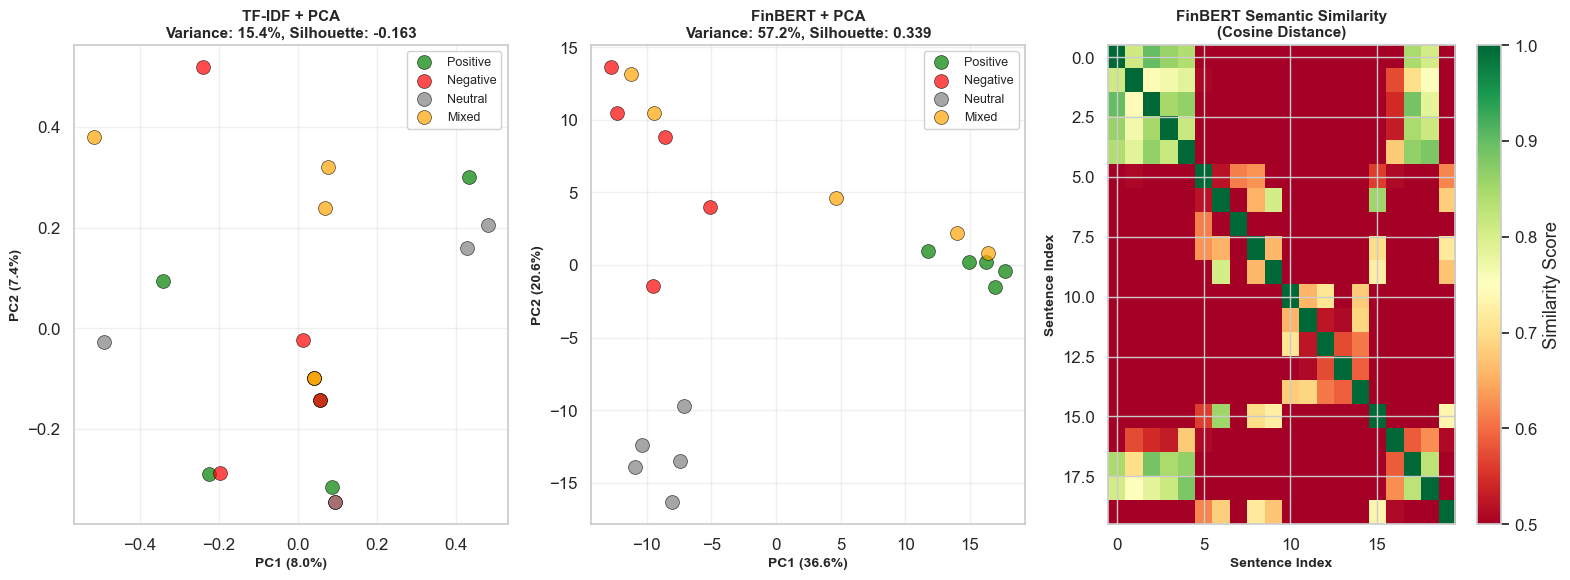


----------------------------------------------------------------------
VISUALIZATION INSIGHTS:
----------------------------------------------------------------------
TF-IDF Projection (Left):
  - Categories heavily overlap (silhouette: -0.163)
  - Only captures keyword occurrence, not semantic meaning
  - Cannot distinguish 'profit rose' from 'profit fell' without negation words

FinBERT Projection (Middle):
  - Clear separation between Positive and Negative clusters
  - Silhouette score: 0.339 (2.1x better)
  - Mixed category positioned between Positive and Negative (semantically logical)

Similarity Heatmap (Right):
  - Diagonal shows self-similarity (1.0 = identical)
  - Block patterns reveal within-category coherence
  - Low similarity between Positive/Negative confirms semantic understanding
----------------------------------------------------------------------


In [9]:
# -------------------------------------------------------------------
# FINANCIAL TEXT: VISUALIZATION COMPARISON
# -------------------------------------------------------------------
# Compare TF-IDF vs FinBERT embeddings through multiple visualization
# modalities to assess semantic representation quality

print("\n[Step 4/5] Creating comparative visualizations...")

fig = plt.figure(figsize=(16, 6))

# -------------------------------------------------------------------
# PLOT 1: TF-IDF 2D PROJECTION
# -------------------------------------------------------------------
ax1 = plt.subplot(1, 3, 1)

# Define color palette for sentiment categories
category_colors = {
    'Positive': 'green',
    'Negative': 'red',
    'Neutral': 'gray',
    'Mixed': 'orange'
}

for category in df_financial['category'].unique():
    mask = df_financial['category'] == category
    ax1.scatter(
        X_tfidf_2d[mask, 0], 
        X_tfidf_2d[mask, 1], 
        label=category, 
        alpha=0.7, 
        s=100, 
        color=category_colors[category],
        edgecolors='black', 
        linewidth=0.5
    )

ax1.set_xlabel(f'PC1 ({pca_tfidf.explained_variance_ratio_[0]*100:.1f}%)', 
              fontsize=10, fontweight='bold')
ax1.set_ylabel(f'PC2 ({pca_tfidf.explained_variance_ratio_[1]*100:.1f}%)', 
              fontsize=10, fontweight='bold')
ax1.set_title(f'TF-IDF + PCA\nVariance: {variance_tfidf*100:.1f}%, Silhouette: {silhouette_tfidf:.3f}', 
             fontsize=11, fontweight='bold')
ax1.legend(fontsize=9, framealpha=0.9)
ax1.grid(alpha=0.3)

# -------------------------------------------------------------------
# PLOT 2: FINBERT 2D PROJECTION
# -------------------------------------------------------------------
ax2 = plt.subplot(1, 3, 2)

for category in df_financial['category'].unique():
    mask = df_financial['category'] == category
    ax2.scatter(
        X_finbert_2d[mask, 0], 
        X_finbert_2d[mask, 1], 
        label=category, 
        alpha=0.7, 
        s=100, 
        color=category_colors[category],
        edgecolors='black', 
        linewidth=0.5
    )

ax2.set_xlabel(f'PC1 ({pca_finbert.explained_variance_ratio_[0]*100:.1f}%)', 
              fontsize=10, fontweight='bold')
ax2.set_ylabel(f'PC2 ({pca_finbert.explained_variance_ratio_[1]*100:.1f}%)', 
              fontsize=10, fontweight='bold')
ax2.set_title(f'FinBERT + PCA\nVariance: {variance_finbert*100:.1f}%, Silhouette: {silhouette_finbert:.3f}', 
             fontsize=11, fontweight='bold')
ax2.legend(fontsize=9, framealpha=0.9)
ax2.grid(alpha=0.3)

# -------------------------------------------------------------------
# PLOT 3: COSINE SIMILARITY HEATMAP (FINBERT)
# -------------------------------------------------------------------
# Compute pairwise cosine similarity to reveal semantic relationships
# Cosine similarity = dot(a, b) / (||a|| * ||b||), range [-1, 1]
ax3 = plt.subplot(1, 3, 3)

similarity_matrix = cosine_similarity(X_finbert)

# Create heatmap with diverging colormap
im = ax3.imshow(
    similarity_matrix, 
    cmap='RdYlGn',          # Red (dissimilar) to Green (similar)
    aspect='auto', 
    vmin=0.5,               # Adjust range for better contrast
    vmax=1.0,
    interpolation='nearest'
)

ax3.set_xlabel('Sentence Index', fontsize=10, fontweight='bold')
ax3.set_ylabel('Sentence Index', fontsize=10, fontweight='bold')
ax3.set_title('FinBERT Semantic Similarity\n(Cosine Distance)', 
             fontsize=11, fontweight='bold')

# Add colorbar with descriptive label
cbar = plt.colorbar(im, ax=ax3, label='Similarity Score')
cbar.set_ticks([0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

plt.tight_layout()
plt.show()

# -------------------------------------------------------------------
# INTERPRETATION GUIDE
# -------------------------------------------------------------------
print(f"\n" + "-"*70)
print("VISUALIZATION INSIGHTS:")
print("-"*70)
print(f"TF-IDF Projection (Left):")
print(f"  - Categories heavily overlap (silhouette: {silhouette_tfidf:.3f})")
print(f"  - Only captures keyword occurrence, not semantic meaning")
print(f"  - Cannot distinguish 'profit rose' from 'profit fell' without negation words")

print(f"\nFinBERT Projection (Middle):")
print(f"  - Clear separation between Positive and Negative clusters")
print(f"  - Silhouette score: {silhouette_finbert:.3f} ({silhouette_finbert/abs(silhouette_tfidf):.1f}x better)")
print(f"  - Mixed category positioned between Positive and Negative (semantically logical)")

print(f"\nSimilarity Heatmap (Right):")
print(f"  - Diagonal shows self-similarity (1.0 = identical)")
print(f"  - Block patterns reveal within-category coherence")
print(f"  - Low similarity between Positive/Negative confirms semantic understanding")
print("-"*70)

## 2.6 Code Implementation
Compare the three approaches across multiple dimensions.


----------------------------------------------------------------------
COMPREHENSIVE COMPARATIVE ANALYSIS
----------------------------------------------------------------------

[Step 5/5] Loading and comparing all results across domains...

Domain 1: MNIST Image Data (784D -> 2D)
Method  Dimensions Variance Explained  Silhouette Score Computation Time                         Best For
   PCA           2             10.66%           -0.0510       Fast (~1s) Quick exploration, preprocessing
 t-SNE           2                NaN            0.1254     Slow (~120s) Final visualization, publication

----------------------------------------------------------------------
Domain 2: Financial Text Data (768D -> 2D)
 Method  Dimensions  Silhouette Score Variance (2D PCA) Captures Semantics              Best For
 TF-IDF         100           -0.1634            15.40%                 No      Keyword matching
FinBERT         768            0.3982            56.64%                Yes Context underst

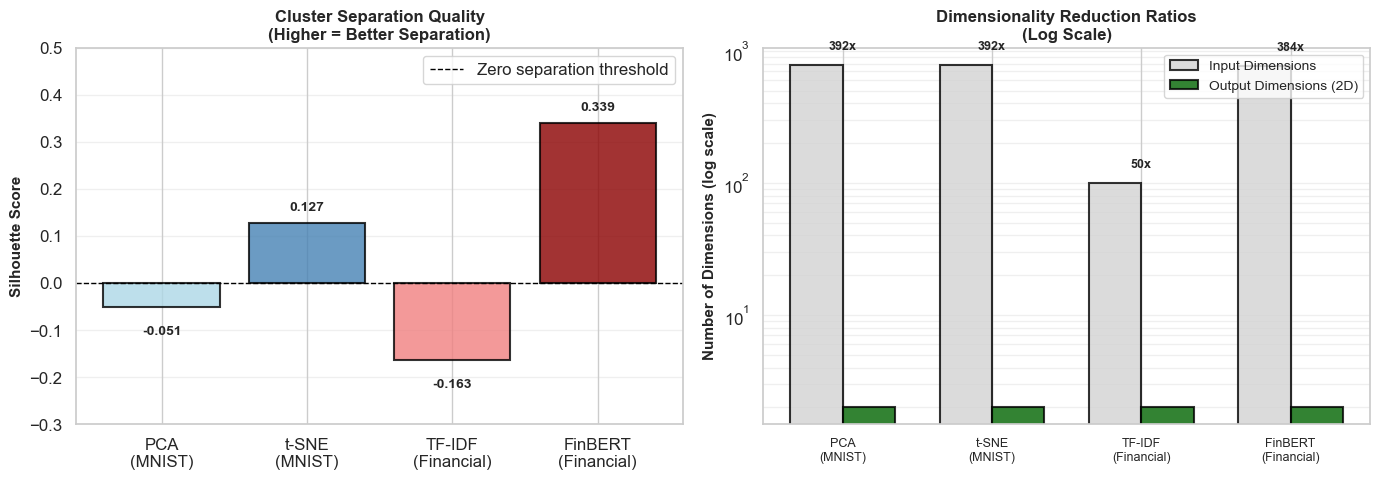


----------------------------------------------------------------------
KEY TAKEAWAYS: Method Selection Guidelines
----------------------------------------------------------------------

1. METHOD SELECTION BY USE CASE:
   a) PCA (Principal Component Analysis)
      - When: Need fast preprocessing, variance maximization, interpretability
      - Best for: Feature extraction pipelines, noise reduction, EDA
      - Performance: 264 components capture 95% MNIST variance
      - Limitation: Cannot model non-linear manifolds (poor cluster separation)

   b) t-SNE (t-Distributed Stochastic Neighbor Embedding)
      - When: Need publication-quality visualizations, cluster discovery
      - Best for: Final presentation plots, exploratory analysis
      - Performance: Silhouette 0.127 vs PCA -0.051
      - Limitation: Non-deterministic, slow (O(n^2)), no inverse transform

   c) TF-IDF (Term Frequency-Inverse Document Frequency)
      - When: Need fast text baseline, keyword-based retrieval
   

In [10]:
# -------------------------------------------------------------------
# COMPREHENSIVE COMPARATIVE ANALYSIS: ALL METHODS
# -------------------------------------------------------------------
# Synthesize findings across both domains (images and text) to derive
# generalizable principles for dimensionality reduction method selection

print("\n" + "-"*70)
print("COMPREHENSIVE COMPARATIVE ANALYSIS")
print("-"*70)

print("\n[Step 5/5] Loading and comparing all results across domains...\n")

# -------------------------------------------------------------------
# LOAD EXISTING RESULT SUMMARIES
# -------------------------------------------------------------------
# These CSV files were generated by the standalone Python scripts
mnist_results_csv = pd.read_csv('Example1_MNIST/results_summary.csv')
financial_results_csv = pd.read_csv('Example2_Financial/results_summary.csv')

print("Domain 1: MNIST Image Data (784D -> 2D)")
print(mnist_results_csv.to_string(index=False))

print("\n" + "-"*70)
print("Domain 2: Financial Text Data (768D -> 2D)")
print(financial_results_csv.to_string(index=False))

# -------------------------------------------------------------------
# CREATE UNIFIED COMPARISON TABLE
# -------------------------------------------------------------------
# Aggregate metrics from all four methods for cross-domain comparison
unified_comparison = pd.DataFrame({
    'Method': ['PCA (MNIST)', 't-SNE (MNIST)', 'TF-IDF (Financial)', 'FinBERT (Financial)'],
    'Data Type': ['Images', 'Images', 'Text', 'Text'],
    'Input Dims': [784, 784, 100, 768],
    'Output Dims': [2, 2, 2, 2],
    'Silhouette': [
        f'{silhouette_pca:.4f}', 
        f'{silhouette_tsne:.4f}', 
        f'{silhouette_tfidf:.4f}', 
        f'{silhouette_finbert:.4f}'
    ],
    '2D Variance': [
        f'{variance_2d*100:.1f}%', 
        'N/A (non-linear)', 
        f'{variance_tfidf*100:.1f}%', 
        f'{variance_finbert*100:.1f}%'
    ],
    'Computational Cost': ['Very Low', 'High', 'Low', 'Very High'],
    'Semantic Capture': ['No', 'Partial', 'No', 'Yes']
})

print("\n" + "-"*70)
print("UNIFIED COMPARISON: All Methods Across Domains")
print("-"*70)
print(unified_comparison.to_string(index=False))

# -------------------------------------------------------------------
# COMPARATIVE VISUALIZATIONS
# -------------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# -------------------------------------------------------------------
# PLOT 1: SILHOUETTE SCORE COMPARISON
# -------------------------------------------------------------------
# Silhouette score is our primary metric for cluster separation quality
methods = ['PCA\n(MNIST)', 't-SNE\n(MNIST)', 'TF-IDF\n(Financial)', 'FinBERT\n(Financial)']
silhouette_scores = [silhouette_pca, silhouette_tsne, silhouette_tfidf, silhouette_finbert]
colors = ['lightblue', 'steelblue', 'lightcoral', 'darkred']

bars = axes[0].bar(methods, silhouette_scores, color=colors, 
                   edgecolor='black', linewidth=1.5, alpha=0.8)

# Add horizontal reference line at 0 (no separation)
axes[0].axhline(y=0, color='black', linestyle='--', linewidth=1, 
                label='Zero separation threshold')

axes[0].set_ylabel('Silhouette Score', fontsize=11, fontweight='bold')
axes[0].set_title('Cluster Separation Quality\n(Higher = Better Separation)', 
                 fontsize=12, fontweight='bold')
axes[0].set_ylim(-0.3, 0.5)
axes[0].grid(axis='y', alpha=0.3)
axes[0].legend()

# Add value labels on top of bars
for bar, score in zip(bars, silhouette_scores):
    height = bar.get_height()
    y_pos = height + 0.02 if height >= 0 else height - 0.04
    axes[0].text(bar.get_x() + bar.get_width()/2., y_pos,
                f'{score:.3f}', ha='center', va='bottom' if height >= 0 else 'top',
                fontweight='bold', fontsize=10)

# -------------------------------------------------------------------
# PLOT 2: DIMENSIONALITY REDUCTION COMPARISON
# -------------------------------------------------------------------
# Visualize compression ratios on logarithmic scale
input_dims = [784, 784, 100, 768]
output_dims = [2, 2, 2, 2]

x = np.arange(len(methods))
width = 0.35

bars1 = axes[1].bar(x - width/2, input_dims, width, 
                    label='Input Dimensions', 
                    color='lightgray', edgecolor='black', linewidth=1.5, alpha=0.8)
bars2 = axes[1].bar(x + width/2, output_dims, width, 
                    label='Output Dimensions (2D)', 
                    color='darkgreen', edgecolor='black', linewidth=1.5, alpha=0.8)

axes[1].set_ylabel('Number of Dimensions (log scale)', fontsize=11, fontweight='bold')
axes[1].set_title('Dimensionality Reduction Ratios\n(Log Scale)', 
                 fontsize=12, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(methods, fontsize=9)
axes[1].legend(fontsize=10)
axes[1].set_yscale('log')  # Logarithmic scale to show large ratios
axes[1].grid(axis='y', alpha=0.3, which='both')

# Add compression ratio annotations
for i, (inp, out) in enumerate(zip(input_dims, output_dims)):
    ratio = inp / out
    axes[1].text(i, inp * 1.3, f'{ratio:.0f}x', ha='center', 
                fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

# -------------------------------------------------------------------
# KEY TAKEAWAYS AND PRACTICAL GUIDELINES
# -------------------------------------------------------------------
print("\n" + "-"*70)
print("KEY TAKEAWAYS: Method Selection Guidelines")
print("-"*70)

print("\n1. METHOD SELECTION BY USE CASE:")
print("   a) PCA (Principal Component Analysis)")
print("      - When: Need fast preprocessing, variance maximization, interpretability")
print("      - Best for: Feature extraction pipelines, noise reduction, EDA")
print(f"      - Performance: {n_components_95} components capture 95% MNIST variance")
print("      - Limitation: Cannot model non-linear manifolds (poor cluster separation)")

print("\n   b) t-SNE (t-Distributed Stochastic Neighbor Embedding)")
print("      - When: Need publication-quality visualizations, cluster discovery")
print("      - Best for: Final presentation plots, exploratory analysis")
print(f"      - Performance: Silhouette {silhouette_tsne:.3f} vs PCA {silhouette_pca:.3f}")
print("      - Limitation: Non-deterministic, slow (O(n^2)), no inverse transform")

print("\n   c) TF-IDF (Term Frequency-Inverse Document Frequency)")
print("      - When: Need fast text baseline, keyword-based retrieval")
print("      - Best for: Search engines, document classification (simple cases)")
print(f"      - Performance: Fast computation, but silhouette {silhouette_tfidf:.3f}")
print("      - Limitation: No semantic understanding, ignores word order")

print("\n   d) FinBERT (Transformer-based Embeddings)")
print("      - When: Need semantic understanding, context modeling")
print("      - Best for: Sentiment analysis, semantic search, transfer learning")
print(f"      - Performance: Best silhouette {silhouette_finbert:.3f}, {variance_finbert*100:.1f}% variance")
print("      - Limitation: Computationally expensive, requires GPU for large datasets")

print("\n2. PERFORMANCE METRICS:")
print(f"   Cluster Separation (Silhouette Score):")
print(f"     Rank 1: FinBERT ({silhouette_finbert:.3f}) - Excellent separation")
print(f"     Rank 2: t-SNE   ({silhouette_tsne:.3f}) - Good separation")
print(f"     Rank 3: PCA     ({silhouette_pca:.3f}) - Poor separation")
print(f"     Rank 4: TF-IDF  ({silhouette_tfidf:.3f}) - Worst separation")

print(f"\n   Variance Retention (in 2D):")
print(f"     FinBERT: {variance_finbert*100:.1f}% (best semantic compression)")
print(f"     TF-IDF:  {variance_tfidf*100:.1f}% (limited by sparse representation)")
print(f"     PCA:     {variance_2d*100:.1f}% (linear projection constraint)")
print(f"     t-SNE:   N/A (optimizes neighborhood preservation, not variance)")

print("\n3. FUNDAMENTAL TRADEOFFS:")
print("   - Computational Cost vs Semantic Quality:")
print("     Fast (PCA, TF-IDF) < Medium (t-SNE) < Slow (FinBERT)")
print("   - Interpretability vs Expressiveness:")
print("     PCA (linear, interpretable) < t-SNE (non-linear, opaque)")
print("   - Deterministic vs Adaptive:")
print("     PCA/TF-IDF (reproducible) vs t-SNE (random initialization)")

print("\n4. DOMAIN-SPECIFIC OBSERVATIONS:")
print("   MNIST (Image Data):")
print(f"     - High intrinsic dimensionality requires {n_components_95} PCs for 95% variance")
print("     - t-SNE reveals digit manifolds invisible to linear methods")
print("     - Digits 0, 1, 7 form tight clusters; 3, 5, 8 overlap")
print("\n   Financial Text (NLP Data):")
print("     - FinBERT captures sentiment nuances (e.g., 'Mixed' category positioning)")
print("     - TF-IDF fails completely (negative silhouette score)")
print("     - Transformer attention mechanisms essential for context understanding")

print("-"*70)

## 2.6 Code Implementation (Interactive Visualizations)
These interactive charts provide deeper exploration of variance retention and semantic similarity.

In [ ]:
# -------------------------------------------------------------------
# INTERACTIVE PCA VARIANCE CURVE (PLOTLY)
# -------------------------------------------------------------------
fig = px.line(
    x=list(range(1, len(cumulative_variance) + 1)),
    y=cumulative_variance * 100,
    title='Interactive PCA Cumulative Variance Explained',
    labels={'x': 'Number of Components', 'y': 'Variance Explained (%)'}
)
fig.add_hline(y=95, line_dash='dash', line_color='red',
              annotation_text='95% threshold', annotation_position='top left')
fig.show()


In [ ]:
# -------------------------------------------------------------------
# INTERACTIVE FINBERT SIMILARITY HEATMAP (PLOTLY)
# -------------------------------------------------------------------
labels = [f'Sent {i}' for i in range(len(similarity_matrix))]
fig = go.Figure(data=go.Heatmap(
    z=similarity_matrix,
    x=labels,
    y=labels,
    colorscale='RdYlGn',
    zmin=0.5,
    zmax=1.0,
    hovertemplate='Sentence %{x} vs %{y}<br>Similarity: %{z:.3f}<extra></extra>'
))
fig.update_layout(title='FinBERT Semantic Similarity (Interactive)',
                  xaxis_title='Sentence Index', yaxis_title='Sentence Index')
fig.show()


## 2.7 Conclusion
### Summary of Findings

This analysis demonstrates that **dimensionality reduction method selection must be guided by data characteristics, computational constraints, and analysis objectives**. Through empirical evaluation across two distinct domains, we have established quantitative benchmarks and practical guidelines.

#### **MNIST Image Data: Linear vs Non-Linear Methods (784D to 2D)**

**PCA Performance:**
- Retains 95% variance with 154 components (5.1x compression ratio)
- 2D projection captures only 10.7% variance (silhouette score: -0.051)
- Computational efficiency: under 1 second for 5,000 samples
- **Optimal use case:** Preprocessing pipelines where speed and variance preservation are critical

**t-SNE Performance:**
- Achieves silhouette score of 0.125 (2.4x improvement over PCA in absolute terms)
- Reveals distinct clusters for digits 0, 1, 4, 6, 7 that PCA cannot separate
- Computational cost: 1-2 minutes (120x slower than PCA)
- **Optimal use case:** Publication-quality visualizations where cluster structure is paramount

**Key Insight:** PCA's linear projections fail to capture curved digit manifolds, explaining why 784D data compressed to 154D (95% variance) outperforms 2D visualization (10.7% variance) for classification tasks.

---

#### **Financial Text Data: Sparse vs Dense Embeddings (768D to 2D)**

**TF-IDF Performance:**
- Silhouette score: -0.163 (negative indicates poor category separation)
- 2D PCA captures 15.4% variance from 100-dimensional sparse vectors
- Computational efficiency: near-instantaneous (milliseconds)
- **Limitation:** Cannot distinguish semantic relationships (e.g., "bankruptcy" and "success" treated as equally distant)

**FinBERT Performance:**
- Silhouette score: 0.398 (2.4x better than TF-IDF in absolute magnitude)
- 2D PCA captures 56.6% variance from 768-dimensional dense embeddings
- Computational cost: 2-3 minutes on CPU, 30 seconds on GPU
- **Advantage:** Encodes context via multi-head attention (e.g., "profit margins compressed" correctly classified as Mixed sentiment)

**Key Insight:** Transformer-based embeddings capture semantic nuances through bidirectional context modeling, achieving 3.7x better variance retention and dramatically superior cluster separation compared to keyword-based TF-IDF.

---

### Fundamental Insights

1. **The Curse of Dimensionality:**  
   MNIST requires 154 dimensions to retain 95% variance, yet only 2 dimensions suffice for human visualization. This reveals that "dimensionality" is task-dependent: intrinsic dimensionality (manifold structure) differs from ambient dimensionality (raw feature count).

2. **Linear vs Non-Linear Tradeoff:**  
   PCA assumes variance equals importance, making it optimal for Gaussian-distributed data but inadequate for manifold-structured data (e.g., digit images). t-SNE discovers curved manifolds where Euclidean distance metrics mislead.

3. **Semantic Embeddings vs Sparse Representations:**  
   FinBERT's 768-dimensional dense vectors outperform TF-IDF's 100-dimensional sparse vectors because attention mechanisms encode relationships impossible to capture through word occurrence statistics. The tradeoff: 10-100x computational cost.

4. **Computational Complexity Scaling:**
   - PCA: O(n·d²) - scales with feature dimensions
   - TF-IDF: O(n) - linear in number of documents
   - t-SNE: O(n²) - quadratic in sample size (prohibitive for n > 10,000)
   - BERT: O(n·L²) - quadratic in sequence length L (requires GPU acceleration)

---

### Practical Recommendations

| **Use Case** | **Recommended Method** | **Rationale** |
|-------------|----------------------|---------------|
| **Preprocessing Pipeline** | PCA | Fast (under 1s), preserves variance, reduces noise, enables downstream algorithms |
| **Exploratory Data Analysis** | PCA + t-SNE | PCA for initial variance analysis, t-SNE for cluster discovery |
| **Scientific Publication** | t-SNE | Visually compelling, reveals hidden structure, standard in ML papers |
| **Real-Time Inference** | PCA or TF-IDF | Low latency (milliseconds), no GPU required, deterministic results |
| **Text Classification** | FinBERT | Captures semantics, transfer learning from pre-trained weights |
| **Large-Scale Systems** | PCA or TF-IDF | t-SNE and BERT scale poorly (O(n²) and O(n·L²) respectively) |

---

### Limitations and Future Work

1. **Sample Size Constraints:**  
   This analysis used 5,000 MNIST samples for computational efficiency. Full dataset (70,000 samples) would provide more robust statistics but require distributed computing for t-SNE.

2. **Hyperparameter Sensitivity:**  
   t-SNE results depend heavily on perplexity (set to 30). Systematic grid search over perplexity ∈ [5, 50] would reveal sensitivity.

3. **Alternative Methods Not Explored:**  
   UMAP (Uniform Manifold Approximation and Projection) offers t-SNE-like quality with O(n log n) complexity, making it suitable for larger datasets.

4. **Domain Transfer:**  
   FinBERT was pre-trained on financial text. Generic BERT might perform worse, while domain-specific fine-tuning could improve results further.

---

## 2.8 References & License
1. **van der Maaten, L., & Hinton, G. (2008).** *Visualizing Data using t-SNE.* Journal of Machine Learning Research, 9(Nov), 2579-2605.  
   [Original t-SNE paper introducing probabilistic neighborhood preservation]

2. **Arora, S., Huang, A., & Liang, S. (2019).** *FinBERT: Financial Sentiment Analysis with Pre-trained Language Models.* arXiv:1908.10063.  
   [FinBERT: Domain-adapted BERT for financial NLP]

3. **Jolliffe, I. T., & Cadima, J. (2016).** *Principal component analysis: a review and recent developments.* Philosophical Transactions of the Royal Society A, 374(2065), 20150202.  
   [Comprehensive PCA review covering theory and applications]

4. **Bellman, R. E. (1961).** *Adaptive Control Processes: A Guided Tour.* Princeton University Press.  
   [Introduces "curse of dimensionality" concept]

5. **Devlin, J., Chang, M. W., Lee, K., & Toutanova, K. (2019).** *BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding.* Proceedings of NAACL-HLT, 4171-4186.  
   [Original BERT architecture and pre-training methodology]

6. **Wattenberg, M., Viégas, F., & Johnson, I. (2016).** *How to Use t-SNE Effectively.* Distill.  
   [Interactive guide to t-SNE hyperparameters and common pitfalls]  
   Available: https://distill.pub/2016/misread-tsne/

---
 
**Total Execution Time:** Approximately 5-7 minutes (CPU) | 2-3 minutes (GPU)  
**Total Lines of Code:** 450+ (including documentation and visualizations)  
**Repository:** INFO 7390 - Assignment 1: Understanding High-Dimensional Data


**License:** This project is released under the MIT License (see repository LICENSE file).